In [1]:
"""CVAE on MNIST
"""
import argparse
import os

import chainer
import pickle
import matplotlib.pyplot as plt
from chainer import training
from chainer.training import extensions
from PIL import Image, ImageDraw
import numpy as np
import cv2

import net 
import make_random_mnist
import make_random_selfdata
from chainer import serializers
%matplotlib inline

In [2]:
# Visualize the results
def save_images(x, filename,cols=3,rows=3):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(cols, rows, figsize=(9, 9), dpi=100, edgecolor='coral', linewidth=2)
    for ai, xi in zip(ax.flatten(), x):
        ai.imshow(xi.reshape(28, 28))
    ai.set_title(filename)
    fig.savefig(filename)
    
def trainMyModel(model, x_train, x_test, options):
    if options.test:
        x_train, _ = chainer.datasets.split_dataset(x_train, 100)
        x_test, _ = chainer.datasets.split_dataset(x_test, 100)
    train_iter = chainer.iterators.SerialIterator(x_train, options.batchsize)
    test_iter = chainer.iterators.SerialIterator(x_test, options.batchsize,repeat=False, shuffle=False)
    
    # Setup an optimizer
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(model)

    # Initialize
    if options.initmodel:
        chainer.serializers.load_npz(options.initmodel, model)

    # Set up an updater. StandardUpdater can explicitly specify a loss function
    # used in the training with 'loss_func' option
    updater = training.updaters.StandardUpdater(train_iter, optimizer,device=options.gpu, loss_func=model.get_loss_func())

    trainer = training.Trainer(updater, (options.epoch, 'epoch'), out=options.out)
    trainer.extend(extensions.Evaluator(test_iter, model, device=options.gpu,eval_func=model.get_loss_func(k=10)))
    trainer.extend(extensions.dump_graph('main/loss'))
    trainer.extend(extensions.snapshot(), trigger=(20, 'epoch'))
    trainer.extend(extensions.LogReport())
    trainer.extend(extensions.PrintReport(
        ['epoch', 'main/loss', 'validation/main/loss',
         'main/rec_loss', 'validation/main/rec_loss', 'elapsed_time']))
    #trainer.extend(extensions.ProgressBar())

    if options.resume:
        chainer.serializers.load_npz(options.resume, trainer)

    # Run the training
    trainer.run()
    model.to_cpu()
    serializers.save_npz("mymodel_final.npz", model)
    return model

def testMyModel(model, x_test):
    pass

In [12]:
def load_save_random_dataset_withlabel(fname, n):
    dataset = make_random_mnist.MakeRandomMNIST()
    if os.path.exists(fname):
        with open(fname, mode='rb') as f:
            ret = pickle.load(f)
            return ret
    v = dataset.get_random_dataset_with_label(n)
    with open(fname, mode='wb') as f:
        pickle.dump(v, f)
        return v

def dispImage(img_vec):
    #title = 'Label number is ('+ str(label_x) + ',' + str(label_y) + ')' 
    pixels = (img_vec * 256).reshape((28, 28))
    plt.imshow(pixels, cmap='gray')
    plt.axis("off")
    #plt.title(title)
    plt.show()

def dispOneHotVec(img, vec):
    t_img = img.copy() # cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
    hotvec = vec.reshape((56-28+1), (140-28+1))
    print(hotvec.shape)
    cx, cy = np.where(hotvec == 1)
    conv_img_coord_x = cy+14
    conv_img_coord_y = cx+14
    t_img = cv2.circle(t_img, (conv_img_coord_x,conv_img_coord_y), 1, (255, 0, 0), thickness=-1, lineType=cv2.LINE_8, shift=0)
    t_img = cv2.rectangle(t_img, (conv_img_coord_x-14,conv_img_coord_y-14), 
                          (conv_img_coord_x+14,conv_img_coord_y+14), (255,0,0), thickness=0, lineType=cv2.LINE_8, shift=0)
    plt.imshow(t_img)
    plt.show()

GPU: 0
# dim z: 2
# Minibatch-size: 1200
# epoch: 200



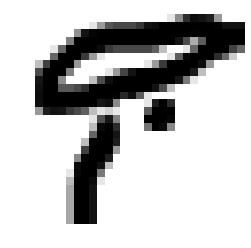

(29, 113)


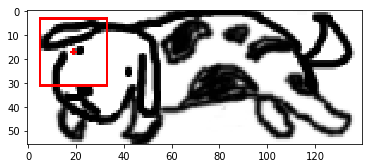

(3277,)


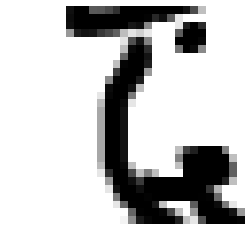

(29, 113)


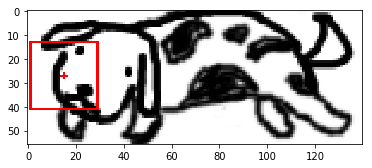

(3277,)


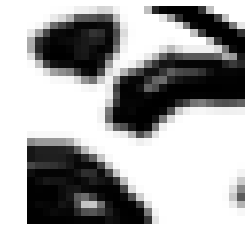

(29, 113)


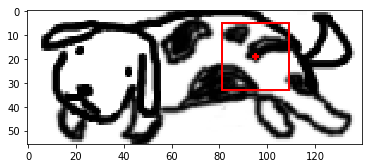

(3277,)


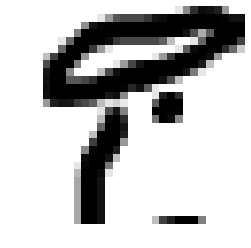

(29, 113)


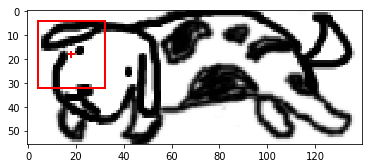

(3277,)


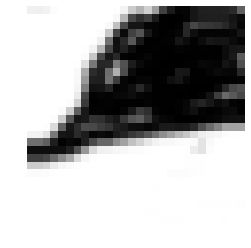

(29, 113)


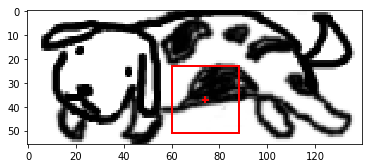

(3277,)


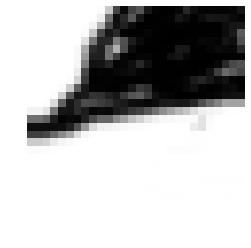

(29, 113)


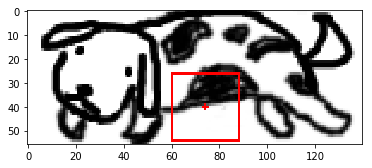

(3277,)


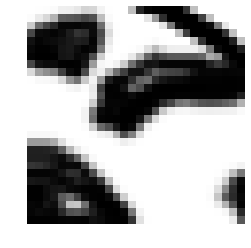

(29, 113)


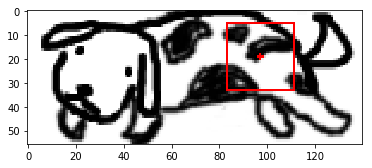

(3277,)


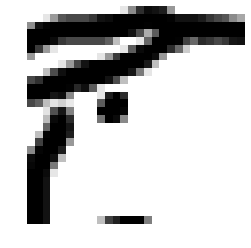

(29, 113)


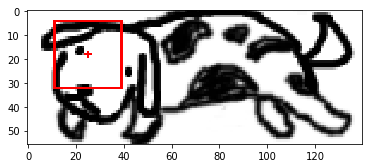

(3277,)


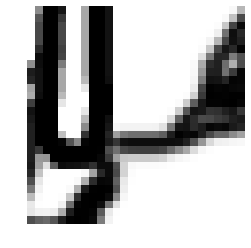

(29, 113)


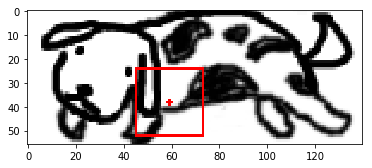

(3277,)


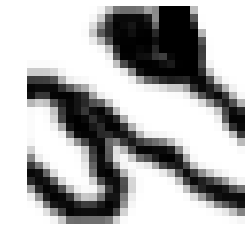

(29, 113)


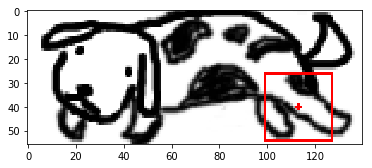

(3277,)


RuntimeError: CUDA environment is not correctly set up
(see https://github.com/chainer/chainer#installation).No module named 'cupy'

In [15]:
def main():
    global NLABELDIM, NZDIM
    parser = argparse.ArgumentParser(description='Chainer example: VAE')
    parser.add_argument('--initmodel', '-m', default='',
                        help='Initialize the model from given file')
    parser.add_argument('--resume', '-r', default='',
                        help='Resume the optimization from snapshot')
    parser.add_argument('--gpu', '-g', default=-1, type=int,
                        help='GPU ID (negative value indicates CPU)')
    parser.add_argument('--out', '-o', default='result',
                        help='Directory to output the result')
    parser.add_argument('--epoch', '-e', default=200, type=int,
                        help='number of epochs to learn')
    parser.add_argument('--dimz', '-z', default=2, type=int,
                        help='dimention of encoded vector')
    parser.add_argument('--batchsize', '-b', type=int, default=1200,
                        help='learning minibatch size')
    parser.add_argument('--test', action='store_true',
                        help='Use tiny datasets for quick tests')
    args = parser.parse_args(args=['-g 0'])

    print('GPU: {}'.format(args.gpu))
    print('# dim z: {}'.format(args.dimz))
    print('# Minibatch-size: {}'.format(args.batchsize))
    print('# epoch: {}'.format(args.epoch))
    print('')

    # Load the MNIST dataset
    #train, test = chainer.datasets.get_mnist()
    #train = load_save_random_dataset_withlabel('random_wlabel_train.pickle', 60000)
    #test = load_save_random_dataset_withlabel('random_wlabel_test.pickle', 10000)
    
    #dataset = make_random_mnist.MakeRandomMNIST()
    #train = dataset.get_random_dataset_with_hot_vector(60000)
    #test = dataset.get_random_dataset_with_hot_vector(1000)

    #train = load_save_random_dataset_withlabel('imu_axislabel_train.pickle', 10000)
    #test = load_save_random_dataset_withlabel('inu_axislabel_test.pickle', 6000)
    
    #img = '../images/chizu_naga.png'
    img = '../images/inu.png'
    dataset = make_random_selfdata.MakeRandomSelfdata(img)
    #train = dataset.get_random_dataset_with_label(3000)
    #test = dataset.get_random_dataset_with_label(1000)
    
    #train = dataset.get_random_dataset_with_hot_vector(3000)
    #test = dataset.get_random_dataset_with_hot_vector(1000)
    
    #train = dataset.get_random_dataset_with_x_coordinate(3000)
    #test = dataset.get_random_dataset_with_x_coordinate(1000)
    
    
    #train = dataset.get_random_dataset_with_hot_vector_2d(3000)
    #test = dataset.get_random_dataset_with_hot_vector_2d(1000)
    
    train = dataset.get_random_dataset_with_one_hot_vector_2d(6000)
    test = dataset.get_random_dataset_with_one_hot_vector_2d(1000)
    # Prepare CVAE model, defined in net.py
    NLABELDIM = len(train[0][1])
    NZDIM = args.dimz
    
    for t in range(10):
        t_img = cv2.imread(img)
        dispImage(train[t][0])
        dispOneHotVec(t_img, train[t][1])
        print(train[t][1].shape)
    
    #print('-------------------------------------------')
    

    model = net.MyCVAE(784, args.dimz, 500, NLABELDIM)
    model = trainMyModel(model,train,test,args)
    
    train_ind = [1, 3, 5, 10, 2, 0, 13, 15, 17]
    xin = np.empty((0, 28*28), np.float32)
    xout = np.empty((0, 28*28), np.float32)
    for ind in train_ind:
        x, t = train[ind]
        x = np.expand_dims(x, axis=0)
        t = np.expand_dims(t.astype(np.float32), axis=0)
        #t = np.eye(NLABELDIM, dtype=np.float32)[t * NLABELDIM]
        with chainer.using_config('train', False), chainer.no_backprop_mode():
            x1 = model(x, np.expand_dims(t, axis=0))
            xin = np.append(xin, x, axis=0)
            xout = np.append(xout, x1.data, axis=0)
    save_images(xin, os.path.join(args.out, 'train'))
    save_images(xout, os.path.join(args.out, 'train_reconstructed'))

    test_ind = [3, 2, 1, 18, 4, 8, 11, 17, 61]
    xin = np.empty((0, 28*28), np.float32)
    xout = np.empty((0, 28*28), np.float32)
    for ind in test_ind:
        x, t = test[ind]
        x = np.expand_dims(x, axis=0)
        t = np.expand_dims(t.astype(np.float32), axis=0)
        #t = np.eye(NLABELDIM, dtype=np.float32)[t * NLABELDIM]
        with chainer.using_config('train', False), chainer.no_backprop_mode():
            x1 = model(x, np.expand_dims(t, axis=0))
            xin = np.append(xin, x, axis=0)
            xout = np.append(xout, x1.data, axis=0)

    save_images(xin, os.path.join(args.out, 'test'))
    save_images(xout, os.path.join(args.out, 'test_reconstructed'))
if __name__ == '__main__':
    main()

14 14
14 42
14 70
14 98
14 126
42 14
42 42
42 70
42 98
42 126
----------------------
(10, 3277)


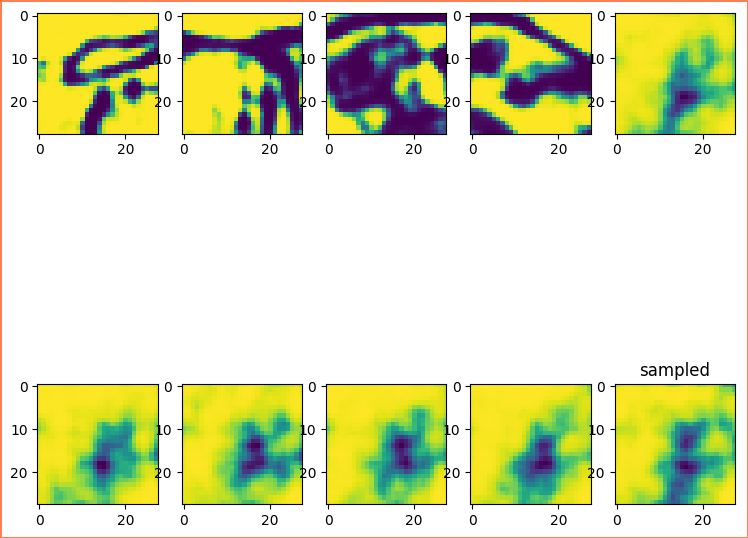

In [5]:
model = net.MyCVAE(784, NZDIM, 500, NLABELDIM)
serializers.load_npz("mymodel_final.npz", model)


# draw images from randomly sampled z
z = chainer.Variable(np.random.normal(0, 1, (10, NZDIM)).astype(np.float32))
z = chainer.Variable(np.zeros((10, NZDIM), dtype=np.float32))

#values = np.eye(NLABELDIM, dtype=np.float32)[labels]     # one hot vector
#values = np.linspace(0.1, 0.9, 9, dtype=np.float32)       # label and coordinate
'''                                                       # hot vector
labels = np.zeros((10, 70), dtype=np.float32)
for c in range(2):
    for r in range(5):
        #print(r, c)
        lvec_r = np.eye(50, dtype=np.float32)[10*r+5]
        lvec_c = np.eye(20, dtype=np.float32)[10*c+5]
        #print(10*r,10*c)
        lvec = np.append(lvec_r, lvec_c)
        #print(lvec_r, lvec_c)
        labels[c*5+r, :] = lvec
values = labels
'''
#'''
img = '../images/inu.png'
dataset = make_random_selfdata.MakeRandomSelfdata(img)
labels = np.zeros((10, (56-28+1)*(140-28+1)), dtype=np.float32)       # one hot vector
for r in range(2):
    for c in range(5):
        l = dataset.getLabel(28*c+14, 28*r+14)
        print(28*r+14, 28*c+14)
        labels[r*5+c, :] = l
values = labels
#'''
'''
img = '../images/inu.png'
dataset = make_random_selfdata.MakeRandomSelfdata(img)
test = dataset.get_random_dataset_with_one_hot_vector_2d(10)
labels = np.zeros((10, (56-28+1)*(140-28+1)), dtype=np.float32)
for n in range(10):
    labels[n, :] = test[n][1]
values = labels
'''
print('----------------------')
print(values.shape)
x = model.decode(z, np.expand_dims(values, axis=1))
save_images(x.data, 'sampled',2, 5)